In this homework, we will use Credit Card Data from book "Econometric Analysis".

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

In [3]:
!wget "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv"

--2022-10-04 19:17:19--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73250 (72K) [text/plain]
Saving to: ‘AER_credit_card_data.csv’

AER_credit_card_dat 100%[===================>]  71.53K  --.-KB/s    in 0.009s  

2022-10-04 19:17:19 (8.03 MB/s) - ‘AER_credit_card_data.csv’ saved [73250/73250]



In [6]:
df = pd.read_csv('AER_credit_card_data.csv')
df.head(3)

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.52,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.42,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.50,0.004156,15.000000,yes,no,4,58,1,5


# Preparation
- Create the target variable by mapping yes to 1 and no to 0.
- Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   card         1319 non-null   object 
 1   reports      1319 non-null   int64  
 2   age          1319 non-null   float64
 3   income       1319 non-null   float64
 4   share        1319 non-null   float64
 5   expenditure  1319 non-null   float64
 6   owner        1319 non-null   object 
 7   selfemp      1319 non-null   object 
 8   dependents   1319 non-null   int64  
 9   months       1319 non-null   int64  
 10  majorcards   1319 non-null   int64  
 11  active       1319 non-null   int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 123.8+ KB


In [9]:
df.isnull().sum()

card           0
reports        0
age            0
income         0
share          0
expenditure    0
owner          0
selfemp        0
dependents     0
months         0
majorcards     0
active         0
dtype: int64

In [10]:
df['card'] = df['card'].map({'yes':1, 'no': 0})

In [11]:
df.head(3)

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,1,0,37.66667,4.52,0.033270,124.983300,yes,no,3,54,1,12
1,1,0,33.25000,2.42,0.005217,9.854167,no,no,3,34,1,13
2,1,0,33.66667,4.50,0.004156,15.000000,yes,no,4,58,1,5


In [13]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train['card']
del df_val['card']
del df_test['card']

In [14]:
len(df_train), len(df_test), len(df_val)

(791, 264, 264)

# Question 1

In [16]:
numerical = ['reports', 'age', 'income', 'share', 'expenditure', 
        'dependents', 'months', 'majorcards', 'active']

categorical = ['owner','selfemp',]

In [17]:
for c in numerical:
  auc = roc_auc_score(y_train, df_train[c]) 

  if auc < 0.5:
    auc = roc_auc_score(y_train, -df_train[c])
  print('%9s, %.3f' %(c, auc))

  reports, 0.717
      age, 0.524
   income, 0.591
    share, 0.989
expenditure, 0.991
dependents, 0.533
   months, 0.529
majorcards, 0.534
   active, 0.604


#Training the model

Training the model From now on, use these columns only:

["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

#Question 2

In [19]:
dv = DictVectorizer(sparse = False)

train_dict = df_train[numerical + categorical].to_dict(orient = 'records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [20]:
val_dict =  df_val[numerical + categorical].to_dict(orient = 'records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

In [23]:
round(roc_auc_score(y_val, y_pred), 3)

0.995

#Question 3

In [24]:
def tpr_fpr_dataframe(y_val, y_pred):

  scores = []
  thresholds = np.linspace(0.0, 1.0, 101)

  for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, tn, fp, fn))

  columns = ['threshold', 'tp', 'fp', 'tn', 'fn']

  df_scores = pd.DataFrame(scores, columns = columns)

  df_scores['tpr'] = df_scores['tp'] / (df_scores['tp'] + df_scores['fn'])
  df_scores['fpr'] = df_scores['fp'] / (df_scores['fp'] + df_scores['tn']) 

  return df_scores

In [31]:
df_tpr_fpr = tpr_fpr_dataframe(y_val, y_pred)
df_tpr_fpr.head(3)

,threshold,tp,fp,tn,fn,tpr,fpr
0,0.00,211,0,53,0,1.0,0.000000
1,0.01,211,19,34,0,1.0,0.358491
2,0.02,211,22,31,0,1.0,0.415094


In [28]:
df_tpr_fpr

,threshold,tp,fp,tn,fn,tpr,fpr,f1
0,0.00,211,0,53,0,1.000000,0.000000,0.000000
1,0.01,211,19,34,0,1.000000,0.358491,0.527778
2,0.02,211,22,31,0,1.000000,0.415094,0.586667
3,0.03,211,29,24,0,1.000000,0.547170,0.707317
4,0.04,211,31,22,0,1.000000,0.584906,0.738095
...,...,...,...,...,...,...,...,...
96,0.96,204,53,0,7,0.966825,1.000000,0.983133
97,0.97,203,53,0,8,0.962085,1.000000,0.980676
98,0.98,203,53,0,8,0.962085,1.000000,0.980676
99,0.99,202,53,0,9,0.957346,1.000000,0.978208


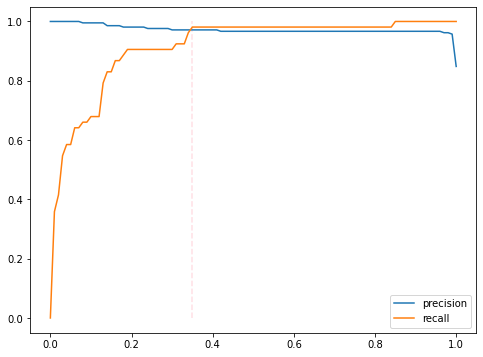

In [26]:
plt.figure(figsize=(8, 6))
plt.plot(df_tpr_fpr.threshold , df_tpr_fpr.tpr, label = 'precision')
plt.plot(df_tpr_fpr.threshold, df_tpr_fpr.fpr, label = 'recall')

plt.vlines(0.35, 0, 1, color='pink', linestyle='--', alpha=0.5)

plt.legend()
plt.show()

# Question 4

In [32]:
df_tpr_fpr['f1'] = 2 * ((df_tpr_fpr.tpr * df_tpr_fpr.fpr) / (df_tpr_fpr.tpr + df_tpr_fpr.fpr))

df_tpr_fpr.head(11)

,threshold,tp,fp,tn,fn,tpr,fpr,f1
0,0.00,211,0,53,0,1.000000,0.000000,0.000000
1,0.01,211,19,34,0,1.000000,0.358491,0.527778
2,0.02,211,22,31,0,1.000000,0.415094,0.586667
3,0.03,211,29,24,0,1.000000,0.547170,0.707317
4,0.04,211,31,22,0,1.000000,0.584906,0.738095
5,0.05,211,31,22,0,1.000000,0.584906,0.738095
6,0.06,211,34,19,0,1.000000,0.641509,0.781609
7,0.07,211,34,19,0,1.000000,0.641509,0.781609
8,0.08,210,35,18,1,0.995261,0.660377,0.793951
9,0.09,210,35,18,1,0.995261,0.660377,0.793951


In [42]:
df_tpr_fpr[df_tpr_fpr['threshold'].isin([0.1,0.4,0.6,0.7])]

,threshold,tp,fp,tn,fn,tpr,fpr,f1
10,0.1,210,36,17,1,0.995261,0.679245,0.807434
40,0.4,205,52,1,6,0.971564,0.981132,0.976325
60,0.6,204,52,1,7,0.966825,0.981132,0.973926


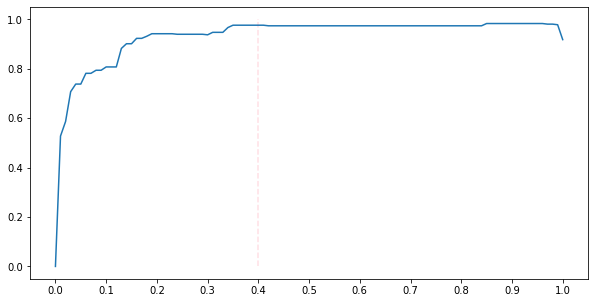

In [43]:
plt.figure(figsize = (10, 5))
plt.plot(df_tpr_fpr.threshold, df_tpr_fpr.f1)
plt.vlines(0.4, 0, 1.0, color='pink', linestyle='--', alpha=0.5)

plt.xticks(np.linspace(0, 1, 11))
plt.show()

#Question 5

In [45]:
def train(df_train, y_train, C = 1.0):
  dicts = df_train[categorical + numerical].to_dict(orient = 'records')

  dv = DictVectorizer(sparse = False)
  X_train = dv.fit_transform(dicts)

  model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
  model.fit(X_train, y_train)

  return dv, model

In [46]:
def predict(df, dv, model):
  dicts = df[categorical + numerical].to_dict(orient = 'records')

  X = dv.transform(dicts)
  y_pred = model.predict_proba(X)[:, 1]

  return y_pred

In [47]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
  df_train = df_full_train.iloc[train_idx]
  df_val = df_full_train.iloc[val_idx]

  y_train = df_train.card.values
  y_val = df_val.card.values

  dv, model = train(df_train, y_train, C=1.0)
  y_pred = predict(df_val, dv, model)

  auc = roc_auc_score(y_val, y_pred)
  scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.996 +- 0.003


#Question 6

In [49]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 1, 10]:
  scores = []

  for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.card.values
    y_val = df_val.card.values

    dv, model = train(df_train, y_train, C=C)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

  print('C=%4s, %.5f +- %.5f' % (C, np.mean(scores), np.std(scores)))

C=0.01, 0.99188 +- 0.00560
C= 0.1, 0.99506 +- 0.00395
C=   1, 0.99645 +- 0.00274
C=  10, 0.99639 +- 0.00282
